In [98]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import time
import fasttext
import hdbscan
import numpy as np
import pandas as pd
from rdkit import Chem
from mordred import Calculator, descriptors

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from openTSNE import TSNE

from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, MiniBatchKMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

In [2]:
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['legend.markerscale'] = 2
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.dpi'] = 100

sns.set_style('ticks')
sns.set_palette('Set1')

In [80]:
def vis_class(X, labels, title=None, file_name=None):
    #core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
    #core_samples_mask[model.core_sample_indices_] = True
    #labels = model.labels_
    
    unique_labels = sorted(set(labels))
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    
    plt.figure(figsize=(15, 12))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
    
        class_member_mask = (labels == k)
    
        xy = X[class_member_mask]
        # print(col)
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
               markeredgecolor='k', markersize=5, label=k)
#         plt.plot(xy[:, 0], xy[:, 1], 'o', 
#                  markeredgecolor='k', markersize=8, label=k)
        if k != -1:
            plt.text(xy[0, 0], xy[0, 1], str(k), fontsize=50)
    
#         xy = X[class_member_mask & ~core_samples_mask]
#         plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#                  markeredgecolor='k', markersize=6, label=k)
    if title:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    if file_name:
        plt.savefig(os.path.join('figures', file_name), bbox_inches='tight', dpi=300)

In [29]:
def reduce_by_tsne(x):
    t0 = time.time()
    tsne = TSNE(n_components=2, n_jobs=4, learning_rate=200, early_exaggeration=20, n_iter=2000, random_state=42, init='pca', verbose=1)
    X_reduced_tsne = tsne.fit_transform(x)
    # X_reduced_tsne = tsne.fit(x)
    print(X_reduced_tsne.shape)
    # np.save('X_reduced_tsne_pca_first', X_reduced_tsne2)
    t1 = time.time()
    print("t-SNE took {:.1f}s.".format(t1 - t0))
    return X_reduced_tsne

In [30]:
def cluster_by_hdbscan(x, min_samples, min_cluster_size):
    print('# min_samples is {}'.format(min_samples), 'min_cluster_size is {}'.format(min_cluster_size))
    cluster = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
    x_normalized = normalize(x, norm='l2')
    cluster_labels = cluster.fit_predict(x_normalized)
    
    n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_ = list(cluster_labels).count(-1)
    
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    return cluster_labels

In [53]:
def cluster_by_dbscan(x, min_samples, eps, metric='euclidean'):
    # x = StandardScaler().fit_transform(x)
    # x = normalize(x, norm='l2')
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, n_jobs=4)
    cluster_labels = clustering.fit_predict(x)
    
    n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_ = list(cluster_labels).count(-1)
    
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    return cluster_labels

In [7]:
def cluster_analysis(md_info, cluster_labels, threshold=0.7, max_top_n=3):
    """
    calculate purity score of each cluster and n_node, class_distribution
    :para md_info: a dataFrame contains the information of molecular descriptors, index/num_md
    :para cluster_labels: a dataFrame contains the label from HDBSCAN algo, index/cluster_labels
    :para threshold: threshold for high-quality cluster based on purity_score
    """
    clusters = cluster_labels.loc[:, 'cluster_labels'].unique()
    cluster_info = {c: {'n_node': 0, 'class_count': {}, 'purity_score_top{}'.format(max_top_n): 0, 'n_class': 0} for c in clusters}
    md_info[md_info >= 1] = 1
    md_label = md_info.apply(lambda x: ''.join([str(i) for i in x]), axis=1)
    md_label = pd.DataFrame(md_label, columns=['md_class'])
    n_clustered_node = 0  # the number of all nodes in high-quality clusters
    purity_score_in_hc = []  # purity score in high-quality clusters
    for c in clusters:
        # print('Current cluster is: {}'.format(c))
        current_nodes = cluster_labels[cluster_labels.cluster_labels == c].index
        current_md_label = md_label.loc[current_nodes, ['md_class']].copy()
        n_node = len(current_nodes)
        # print(current_md_label.head(2))
        class_value_counts = current_md_label['md_class'].value_counts().sort_values(ascending=False)
        class_count = class_value_counts.to_dict()
        top_n = min(max_top_n, len(class_count))
        purity_score = np.sum(list(class_value_counts/n_node)[:top_n])  # sum top_n purity score together
        
        cluster_info[c]['n_node'] = n_node
        cluster_info[c]['class_count'] = class_count
        cluster_info[c]['n_class'] = len(class_count)
        cluster_info[c]['purity_score_top{}'.format(max_top_n)] = '{:.2f}'.format(purity_score)
        if purity_score >= threshold:
            n_clustered_node += n_node
            purity_score_in_hc.append(purity_score)
        if len(purity_score_in_hc) >= 1:
            mean_ps = '{:.2f}'.format(np.mean(purity_score_in_hc))
        else:
            mean_ps = 0
    return {'cluster_info': cluster_info, 'mean_purity_score': mean_ps, 'n_clustered_node': n_clustered_node}

In [8]:
def show_each_md(x_reduced, frag_info, file_path=''):
    """
    reduced_x: 2 dimensions x with fragment as index, a dataframe
    frag_info: the number of each MD with fragemnt as index, a dataframe
    """
    # model = model_name
    fig, ax = plt.subplots(2, 4, figsize=(24, 12))
    ax = ax.flatten()
    # print(x_reduced.head(2))
    # print(frag_info.head(2))
    intersect_index = set(x_reduced.index.to_list()) & set(frag_info.index.to_list())
    x_reduced = x_reduced.loc[intersect_index, :].copy()  # alignment
    frag_info = frag_info.loc[intersect_index, :].copy()
    # reduced_x = reduced_x.loc[frag_info.index, :].copy()
    # parallel_frag_info = parallel_frag_info.loc[:, selected_md].copy()
    for i,md in enumerate(frag_info.columns.to_list()):
        # current_labels = parallel_frag_info.iloc[:, i]
        current_labels = frag_info.iloc[:, i]
        unique_labels = sorted(current_labels.unique())
        n_labels = len(unique_labels)
        # print(n_labels)
        cc = sns.color_palette('Blues', n_labels)
        for j,label in enumerate(unique_labels):
            current_nodes = (current_labels == label)
            ax[i].scatter(x_reduced.loc[current_nodes, 0], x_reduced.loc[current_nodes, 1],
                          c=colors.rgb2hex(cc[j]), vmin=0, vmax=10, s=10, label=str(label))
        ax[i].set_title(md, fontsize=12)
        ax[i].legend()
    plt.tight_layout()
    plt.savefig(file_path, bbox_inches='tight', transparent=True)
    plt.close()

In [110]:
def draw_multiple_mol(smiles_list, mols_per_row=4, file_path=None, legends=None, maxMols=50):
    mols = []
    for i in smiles_list:
        mols.append(Chem.MolFromSmiles(i))
    mols_per_row = min(len(smiles_list), mols_per_row)
    if legends is None:
        img=Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(220, 120), useSVG=True, maxMols=maxMols)
    else:
        img=Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(220, 120), useSVG=True, legends=legends, maxMols=maxMols)
    if file_path:
        with open(file_path, 'w') as f_handle:
            f_handle.write(img.data)
    return img

In [9]:
mol2vec = pd.read_csv('./parallel/all_x_after_trained_parallel_model.csv', index_col=0)
mol2vec.head(2)

,0.1,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,,,,,,,,,,,,,,,,,,,,,
id6,-1.499594,4.795064,-1.682328,3.634081,2.648775,-1.290213,1.098553,-1.721439,0.142399,-1.757469,...,1.611947,-0.746514,-0.910748,0.334813,-1.757399,1.627908,0.670884,-1.455732,5.117005,-1.614040
id8,-1.740047,8.122423,-1.756263,1.207755,0.971331,-1.728168,4.421060,-1.726883,-1.115949,-1.740837,...,-1.353415,-1.085281,3.865592,-1.224507,-1.758050,-1.690312,-0.845013,-1.326752,11.165923,-1.721184


In [10]:
y_test = pd.read_csv('./parallel/y_test.csv', index_col=0)
y_test.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id27,0,0,1,0,1,0,1,0
id39,1,0,1,0,1,1,1,1


In [13]:
y_test_class = y_test.copy()
y_test_class[y_test>=1] = 1
y_test_class['class'] = y_test_class.apply(lambda x: ''.join([str(i) for i in x]), axis=1)
y_test_class.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing,class
0,,,,,,,,,
id27,0,0,1,0,1,0,1,0,00101010
id39,1,0,1,0,1,1,1,1,10101111


#### chose 10101010 class which has low accuracy in prediction task and doesn't show in training set

In [14]:
y_selected = y_test_class[y_test_class['class'] == '10101010'].copy()
y_selected.shape

(5000, 9)

In [15]:
mol2vec_selected = mol2vec.loc[y_selected.index].copy()
mol2vec_selected.head(2)

,0.1,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,,,,,,,,,,,,,,,,,,,,,
id263,-1.708784,3.771039,-1.757655,3.070128,7.484797,0.365535,0.023285,-1.740486,-1.337698,-1.758087,...,-1.319956,3.187580,1.033712,2.178887,-1.754523,0.474725,0.198267,-1.709373,5.527361,-0.789549
id470,-1.753271,-1.060282,-1.733995,1.601165,5.721404,0.215031,1.585439,-1.699480,-1.415751,-1.758096,...,-0.929340,0.106903,-1.543208,6.624198,-1.734029,1.053174,-1.350317,2.326648,5.512983,-1.710908


In [17]:
x_reduced = reduce_by_tsne(mol2vec_selected)
x_reduced_df = pd.DataFrame(data=x_reduced, index=mol2vec_selected.index)
x_reduced_df.head(2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.017s...
[t-SNE] Computed neighbors for 5000 samples in 0.714s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.014933
[t-SNE] KL divergence after 250 iterations with early exaggeration: 142.886383
[t-SNE] KL divergence after 2000 iterations: 0.852714
(5000, 2)
t-SNE took 57.9s.


,0,1
0,,
id263,-62.173195,20.385443
id470,50.347786,45.407898


In [75]:
cluster_labels = cluster_by_dbscan(x=x_reduced, min_samples=10, eps=5)

Estimated number of clusters: 16
Estimated number of noise points: 36


In [72]:
# gmm = BayesianGaussianMixture(n_components=10, max_iter=2000)
# cluster_labels = gmm.fit_predict(mol2vec_selected)

In [76]:
cluster_labels

array([0, 1, 2, ..., 3, 4, 4])

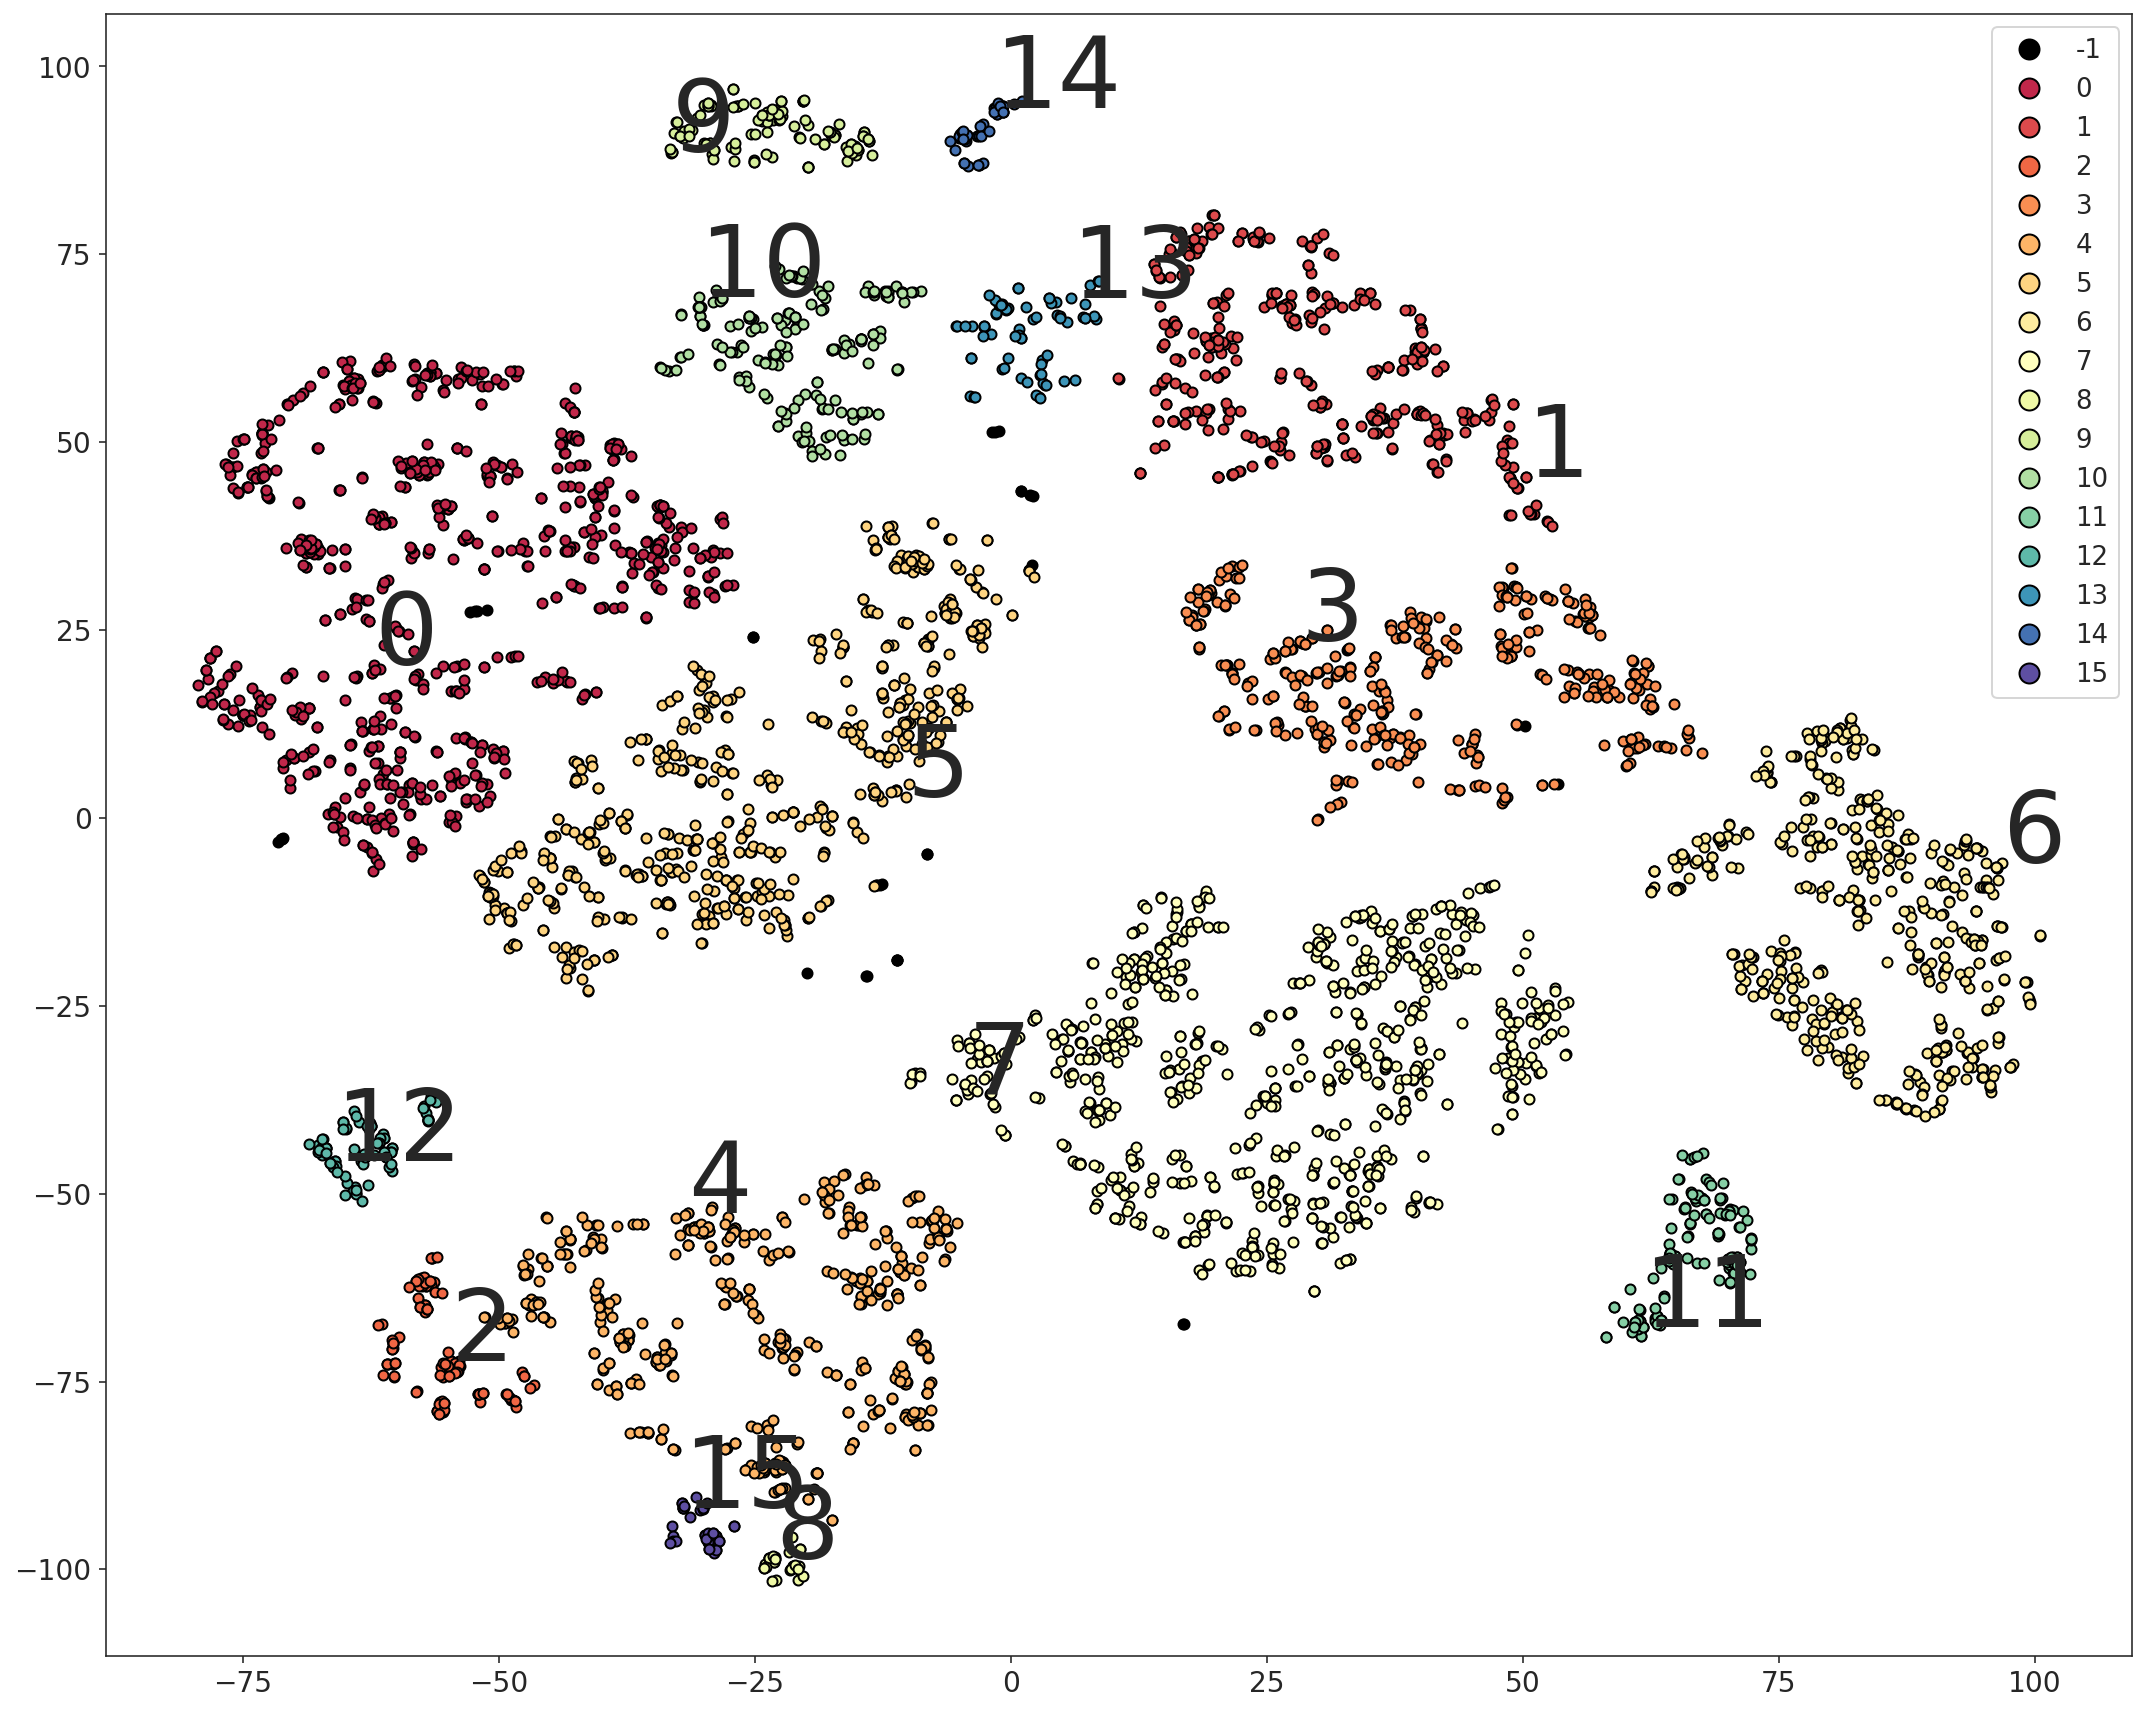

In [81]:
vis_class(x_reduced, cluster_labels, file_name='cluster_10101010_t-SNE_dbscan.png')

In [78]:
x_reduced_df['cluster_labels'] = cluster_labels
x_reduced_df.head(2)

,0,1,cluster_labels
0,,,
id263,-62.173195,20.385443,0
id470,50.347786,45.407898,1


In [82]:
class2count = x_reduced_df['cluster_labels'].value_counts().to_dict()

In [85]:
sampled_mol = {}
n = 6
for i,j in class2count.items():
    if i != -1:
        n = min(n, j)
        current_class = x_reduced_df[x_reduced_df['cluster_labels'] == i].copy()
        sampled_mol[i] = np.random.choice(current_class.index.to_list(), n, replace=False)

In [90]:
sampled_mol_df = pd.DataFrame.from_dict(data=sampled_mol, orient='index')
sampled_mol_df.sort_index(inplace=True)
sampled_mol_df.head(2)

,0,1,2,3,4,5
0,id586736,id1302077,id826746,id1124773,id254871,id1315989
1,id1467786,id470,id1222251,id755575,id946380,id1231757


In [95]:
cid2smiles = pd.read_csv('./parallel/cid2smiles_all_in_train_test.csv', index_col=0).to_dict()['smiles']
cid2smiles['id6']

'CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O'

In [97]:
sampled_mol_df.replace(cid2smiles, inplace=True)
sampled_mol_df.head(2)

,0,1,2,3,4,5
0,COc1ccc(CNC(=O)c2ccc[nH]c2=O)c(OC)c1,COC(=O)NC(C(=O)NCc1cn(-c2ccccc2)nn1)C(C)C,CC(=O)Nc1cc(C(=O)NCCOc2cccc(C)c2)ccc1C,COc1ccc(C)cc1C(C)NC(=O)c1c(C)c(C)nn(C)c1=O,CCNC(=O)c1cccc(NC(=O)C(CC)Oc2ccccc2)c1,Cc1cccc(CCCOC(=O)c2cc(C(N)=O)cn2C)n1
1,Cc1cccc(C(=O)N(C)CCNC(=O)C(C)C)c1C,CCN(CC)C(=O)c1cccc(C(=O)N(CC)CC)c1,Cc1ccc(N(C)C(=O)CCn2ccccc2=O)c(C)c1,Cc1cc(C)n(CCC(=O)N(C)Cc2cc(C(C)(C)C)n[nH]2)c(=...,CCN(C)C(=O)c1cccc(C(=O)Nc2cnc(C(C)(C)C)nc2)c1,CC(=O)c1c(C)[nH]c(C(=O)N(c2ccccc2)C(C)C)c1C


In [106]:
smiles_list = []
legends = []
for i in sampled_mol_df.index:
    current_smiles = sampled_mol_df.loc[i, :].to_list()
    legends += [str(i)] * len(current_smiles)
    smiles_list += current_smiles
print(len(smiles_list))

96


In [105]:
legends, smiles_list

([0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  7,
  7,
  8,
  8,
  8,
  8,
  8,
  8,
  9,
  9,
  9,
  9,
  9,
  9,
  10,
  10,
  10,
  10,
  10,
  10,
  11,
  11,
  11,
  11,
  11,
  11,
  12,
  12,
  12,
  12,
  12,
  12,
  13,
  13,
  13,
  13,
  13,
  13,
  14,
  14,
  14,
  14,
  14,
  14,
  15,
  15,
  15,
  15,
  15,
  15],
 ['COc1ccc(CNC(=O)c2ccc[nH]c2=O)c(OC)c1',
  'COC(=O)NC(C(=O)NCc1cn(-c2ccccc2)nn1)C(C)C',
  'CC(=O)Nc1cc(C(=O)NCCOc2cccc(C)c2)ccc1C',
  'COc1ccc(C)cc1C(C)NC(=O)c1c(C)c(C)nn(C)c1=O',
  'CCNC(=O)c1cccc(NC(=O)C(CC)Oc2ccccc2)c1',
  'Cc1cccc(CCCOC(=O)c2cc(C(N)=O)cn2C)n1',
  'Cc1cccc(C(=O)N(C)CCNC(=O)C(C)C)c1C',
  'CCN(CC)C(=O)c1cccc(C(=O)N(CC)CC)c1',
  'Cc1ccc(N(C)C(=O)CCn2ccccc2=O)c(C)c1',
  'Cc1cc(C)n(CCC(=O)N(C)Cc2cc(C(C)(C)C)n[nH]2)c(=O)n1',
  'CCN(C)C(=O)c1cccc(C(=O)Nc2cnc(C(C)(C

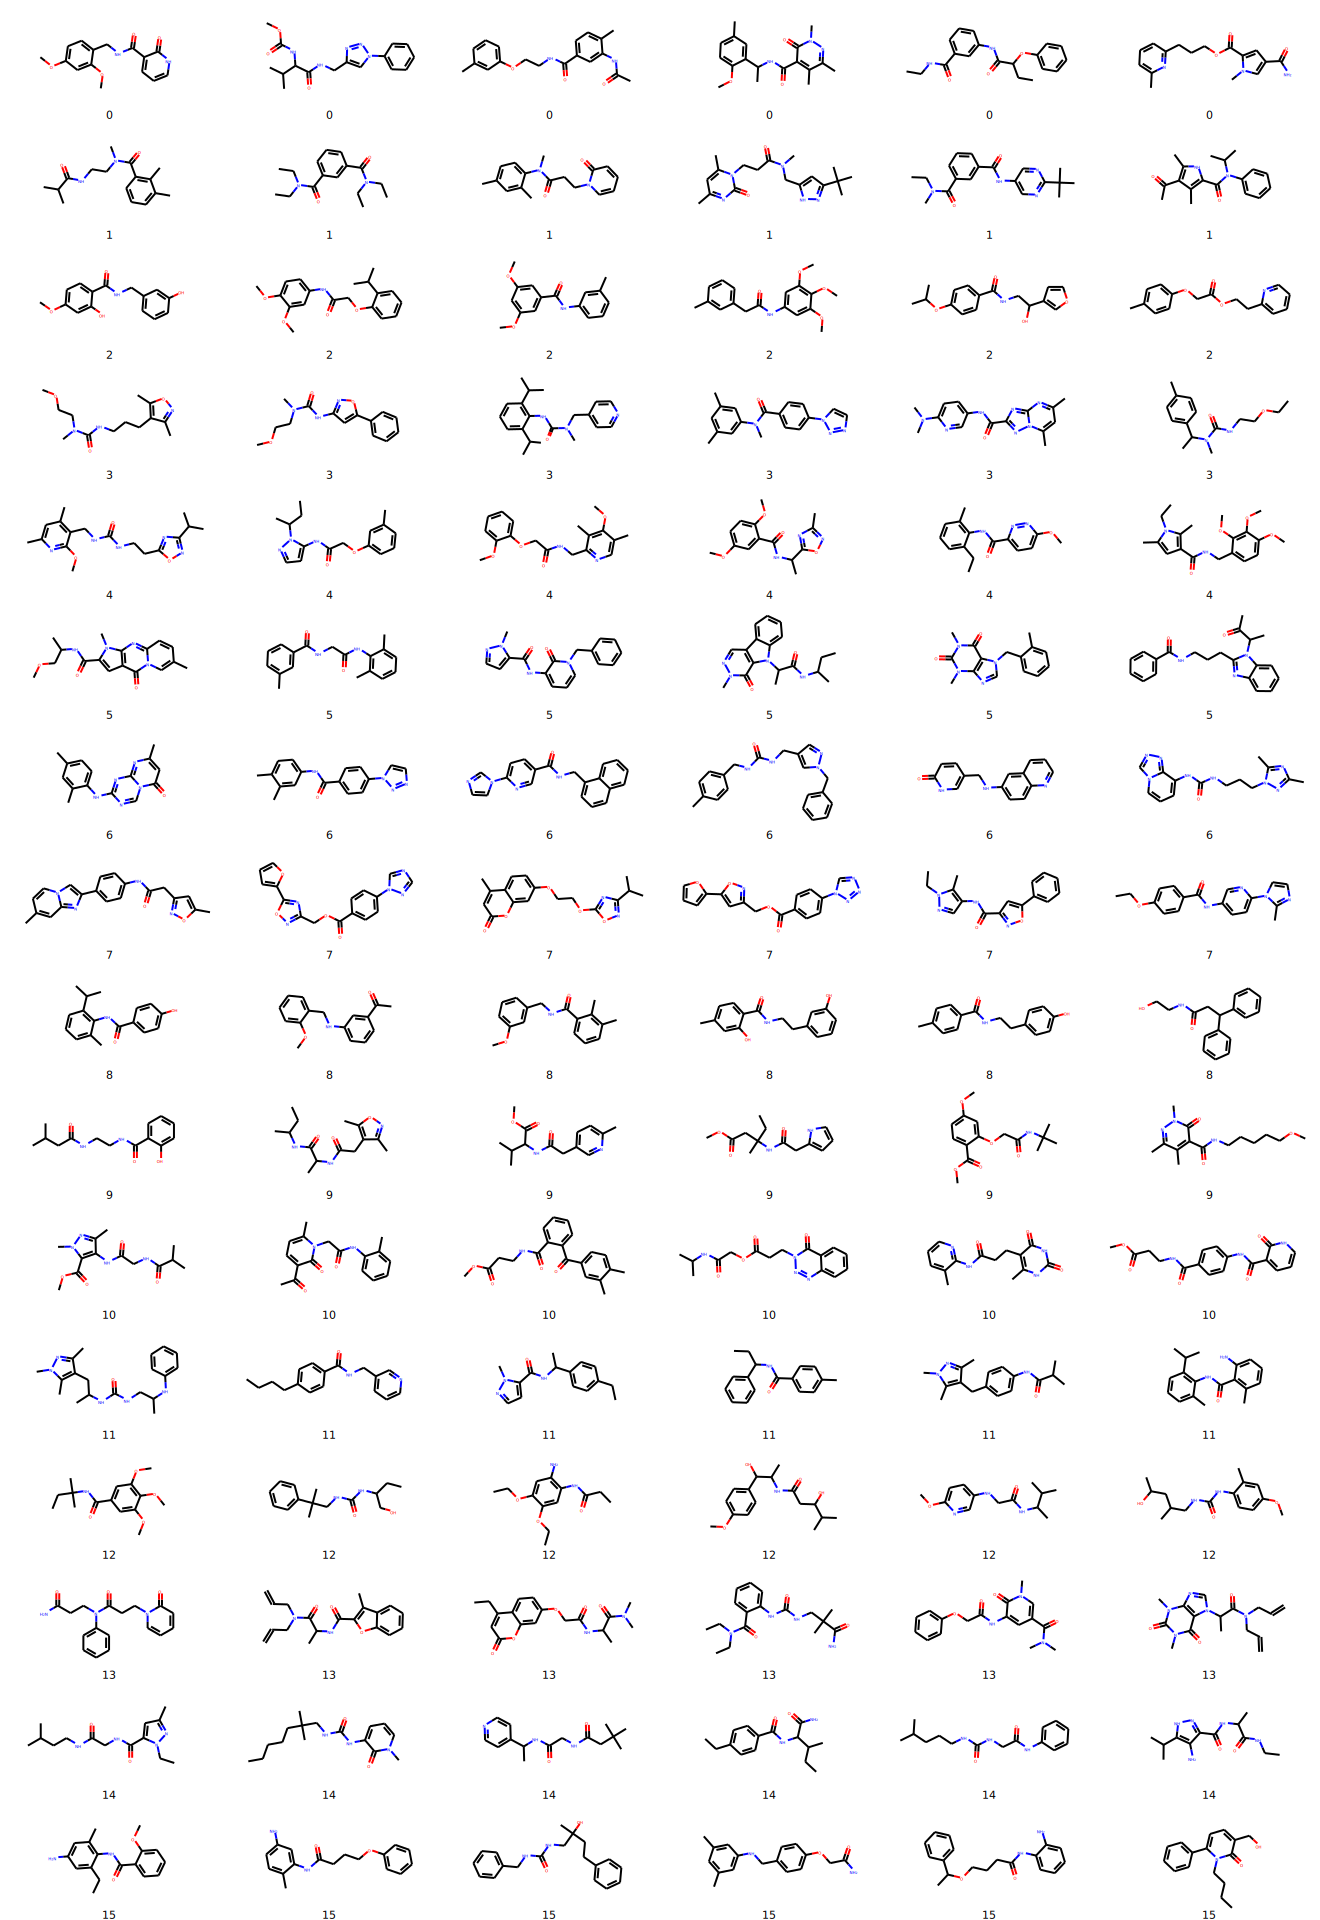

In [111]:
draw_multiple_mol(smiles_list=smiles_list, mols_per_row=6, 
                  file_path='./figures/cluster_10101010_6_mol_for_each_cluster.svg', legends=legends, maxMols=96)